<br>

I used ResNet architecture with the imagenet weights.

<br>

## Predictions

<br>

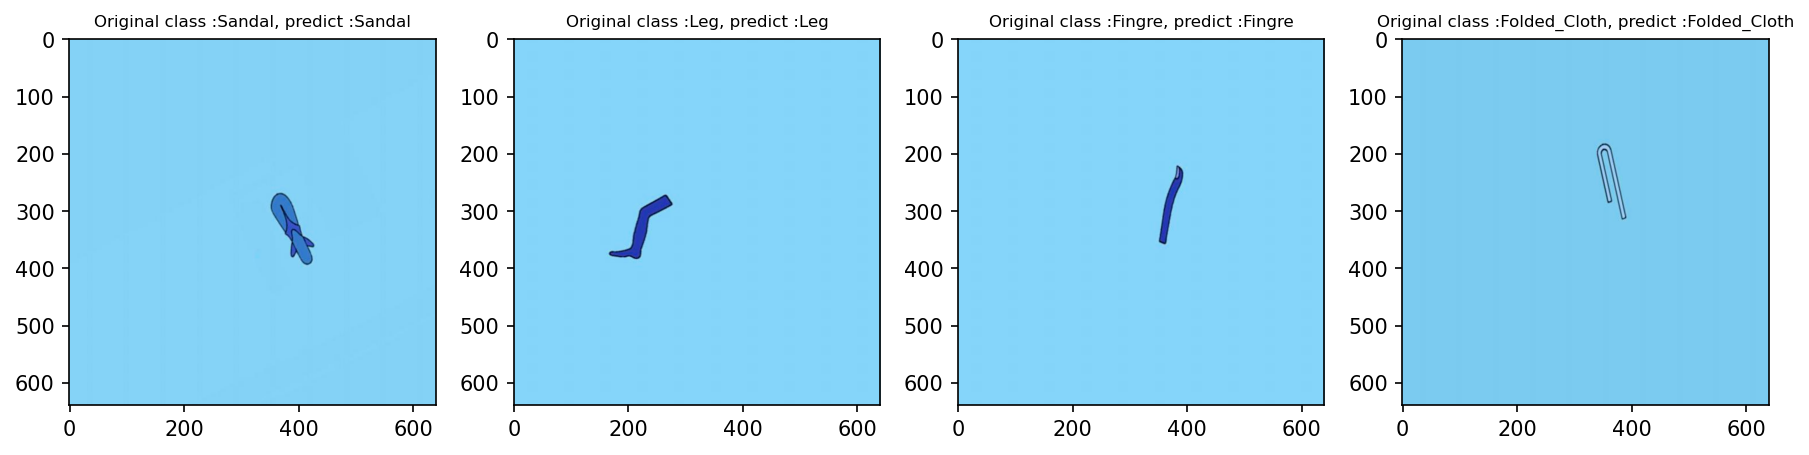


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import random

from sklearn.metrics import classification_report, confusion_matrix,average_precision_score

from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D,BatchNormalization, Activation,Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(10)

In [2]:
train_data = pd.read_csv('/kaggle/input/egyptian-hieroglyphs/train/_annotations.csv')
val_data = pd.read_csv('/kaggle/input/egyptian-hieroglyphs/valid/_annotations.csv')
test_data = pd.read_csv('/kaggle/input/egyptian-hieroglyphs/test/_annotations.csv')

In [3]:
oe = OrdinalEncoder()

# Encoding class labels in the train set
main_path_train = '/kaggle/input/egyptian-hieroglyphs/train/'
train_data['filename'] = train_data['filename'].apply(lambda x: main_path_train + x)

oe.fit(np.array(train_data['class']).reshape(-1,1))
train_data['class'] = oe.transform(np.array(train_data['class']).reshape(-1,1))

# Encoding class labels in the validation set
main_path_val = '/kaggle/input/egyptian-hieroglyphs/valid/'
val_data['filename'] = val_data['filename'].apply(lambda x: main_path_val + x)
val_data['class'] = oe.transform(np.array(val_data['class']).reshape(-1,1))


# Encoding class labels in the test set
main_path_test = '/kaggle/input/egyptian-hieroglyphs/test/'
test_data['filename'] = test_data['filename'].apply(lambda x: main_path_test + x)
test_data['class'] = oe.transform(np.array(test_data['class']).reshape(-1,1))

In [4]:
# Creating random 3 sample from a dataframe

def create_random_samples(data):
    fig, axs = plt.subplots(1,3, figsize = (12,5), dpi = 130)
    
    idx1 = random.randint(0,data.shape[0])
    img1 = cv2.imread(data['filename'][idx1])
    name1 = oe.inverse_transform(np.array(data['class'][idx1]).reshape(-1,1))[0][0]
    
    idx2 = random.randint(0,data.shape[0])
    img2 = cv2.imread(data['filename'][idx2])
    name2 = oe.inverse_transform(np.array(data['class'][idx2]).reshape(-1,1))[0][0]
    
    idx3 = random.randint(0,data.shape[0])
    img3 = cv2.imread(data['filename'][idx3])
    name3 = oe.inverse_transform(np.array(data['class'][idx3]).reshape(-1,1))[0][0]
    
    
    axs[0].imshow(img1)
    axs[0].set_title(name1)

    axs[1].imshow(img2)
    axs[1].set_title(name2)
    
    axs[2].imshow(img3)
    axs[2].set_title(name3)
    
    
    plt.show()

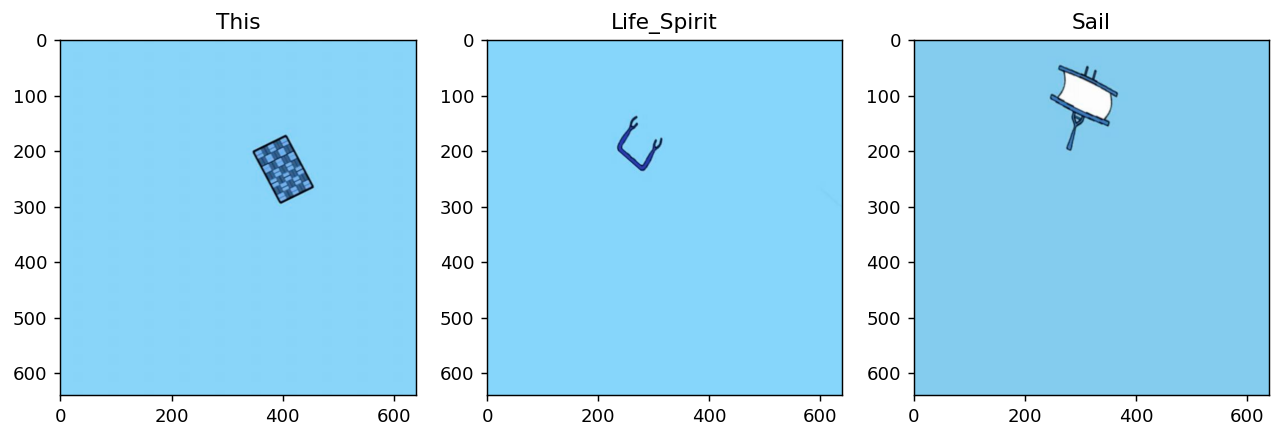

In [5]:
# Training samples

create_random_samples(train_data)

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [6]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (250,250))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label
    

In [7]:
BATCH_SIZE = 32

train_loader = tf.data.Dataset.from_tensor_slices((train_data['filename'], train_data['class']))
train_dataset = (train_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(train_data.shape[0]).prefetch(BATCH_SIZE) )

val_loader = tf.data.Dataset.from_tensor_slices((val_data['filename'], val_data['class']))
val_dataset = (val_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(val_data.shape[0]).prefetch(BATCH_SIZE) )

test_loader = tf.data.Dataset.from_tensor_slices((test_data['filename'], test_data['class']))
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE) )

# <span style="color:#e74c3c;"> DenseNet </span> Model


In [8]:
pretrained_model = tf.keras.applications.DenseNet169(weights='imagenet',include_top=False ,input_shape=[250,250, 3])
pretrained_model.trainable = True

model = tf.keras.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.1),
    
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.1),
    
    Dense(len(oe.categories_[0]), activation = 'softmax') #nclasses = 95
    
])

model.compile(optimizer  = tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                         

# <span style="color:#e74c3c;"> Training </span> 


In [9]:
hist = model.fit(train_dataset, epochs = 8 , validation_data = val_dataset, callbacks = [EarlyStopping(min_delta =0.0001, patience = 2)])

Epoch 1/8
86/86 [==============================] - 165s 415ms/step - loss: 4.5259 - accuracy: 0.0279 - val_loss: 4.5821 - val_accuracy: 0.0116
Epoch 2/8
86/86 [==============================] - 31s 305ms/step - loss: 3.7362 - accuracy: 0.1722 - val_loss: 4.5120 - val_accuracy: 0.0231
Epoch 3/8
86/86 [==============================] - 31s 305ms/step - loss: 3.2260 - accuracy: 0.3731 - val_loss: 4.1989 - val_accuracy: 0.0784
Epoch 4/8
86/86 [==============================] - 31s 304ms/step - loss: 2.8521 - accuracy: 0.5600 - val_loss: 3.8992 - val_accuracy: 0.1645
Epoch 5/8
86/86 [==============================] - 30s 305ms/step - loss: 2.5249 - accuracy: 0.7128 - val_loss: 3.6009 - val_accuracy: 0.2931
Epoch 6/8
86/86 [==============================] - 30s 306ms/step - loss: 2.2643 - accuracy: 0.8197 - val_loss: 3.1689 - val_accuracy: 0.4846
Epoch 7/8
86/86 [==============================] - 30s 305ms/step - loss: 2.0460 - accuracy: 0.8986 - val_loss: 2.7093 - val_accuracy: 0.6928
Epoch

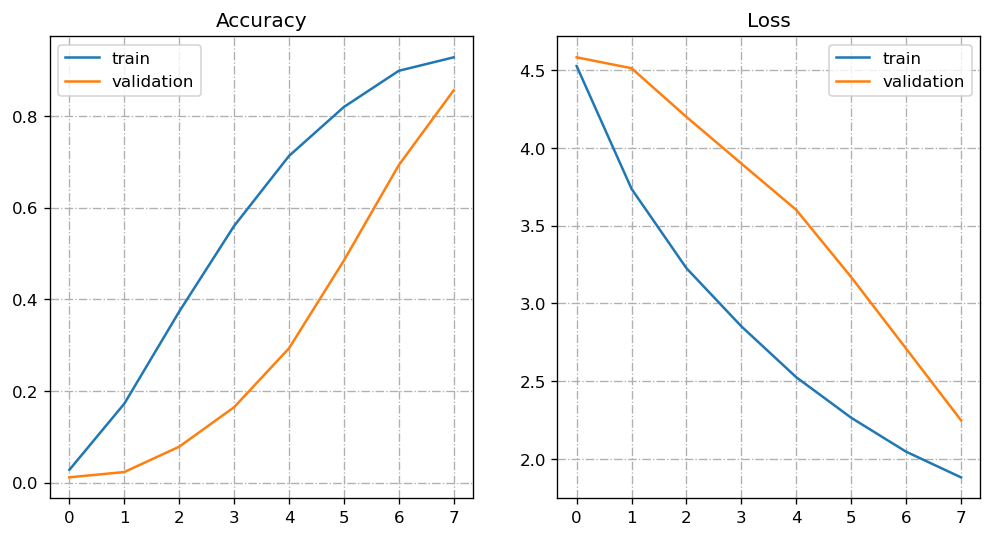

In [10]:
fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 120)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Accuracy")
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].legend(["train", "validation"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Loss")
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].legend(["train", "validation"])

# <span style="color:#e74c3c;"> Evaluation </span> 


In [11]:
test_eval = model.evaluate(test_dataset)
print('test accuracy : {0:.3f} %'.format(test_eval[1]*100))

13/13 [==============================] - 3s 265ms/step - loss: 2.3086 - accuracy: 0.8535
test accuracy : 85.347 %


# <span style="color:#e74c3c;"> Prediction </span> 


In [12]:
pred = model.predict(test_dataset)
pred_ = np.argmax(pred, axis = 1)

13/13 [==============================] - 4s 81ms/step


In [13]:
# Classification report 

report = classification_report(np.array(test_data['class']), pred_)
print(report)

              precision    recall  f1-score   support

         0.0       0.38      1.00      0.55         3
         1.0       1.00      0.88      0.93         8
         2.0       1.00      1.00      1.00         3
         3.0       0.67      1.00      0.80         2
         4.0       1.00      0.83      0.91         6
         5.0       1.00      0.67      0.80         3
         6.0       1.00      1.00      1.00         6
         7.0       1.00      1.00      1.00         1
         8.0       1.00      1.00      1.00         7
         9.0       0.89      1.00      0.94         8
        10.0       1.00      0.80      0.89         5
        11.0       1.00      1.00      1.00         3
        12.0       1.00      1.00      1.00         1
        13.0       0.00      0.00      0.00         1
        14.0       0.60      1.00      0.75         3
        15.0       0.67      1.00      0.80         2
        16.0       1.00      1.00      1.00         2
        17.0       1.00    

In [14]:
# Creating random 3 sample from a dataframe

def create_random_samples_and_prediction(data,pred):
    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 150)
    
    idx1 = random.randint(0,data.shape[0])
    img1 = cv2.imread(data['filename'][idx1])
    name1 = oe.inverse_transform(np.array(data['class'][idx1]).reshape(-1,1))[0][0]
    pred1 = oe.inverse_transform(np.array(pred[idx1]).reshape(-1,1))[0][0]
    
    idx2 = random.randint(0,data.shape[0])
    img2 = cv2.imread(data['filename'][idx2])
    name2 = oe.inverse_transform(np.array(data['class'][idx2]).reshape(-1,1))[0][0]
    pred2 = oe.inverse_transform(np.array(pred[idx2]).reshape(-1,1))[0][0]

    idx3 = random.randint(0,data.shape[0])
    img3 = cv2.imread(data['filename'][idx3])
    name3 = oe.inverse_transform(np.array(data['class'][idx3]).reshape(-1,1))[0][0]
    pred3 = oe.inverse_transform(np.array(pred[idx3]).reshape(-1,1))[0][0]
    
    idx4 = random.randint(0,data.shape[0])
    img4 = cv2.imread(data['filename'][idx4])
    name4 = oe.inverse_transform(np.array(data['class'][idx4]).reshape(-1,1))[0][0]
    pred4 = oe.inverse_transform(np.array(pred[idx4]).reshape(-1,1))[0][0]

    
    axs[0].imshow(img1)
    axs[0].set_title("Original class :" + name1 + ", predict :" + pred1, fontsize=8 )

    axs[1].imshow(img2)
    axs[1].set_title("Original class :" + name2 + ", predict :" + pred2, fontsize=8 )
    
    axs[2].imshow(img3)
    axs[2].set_title("Original class :" + name3 + ", predict :" + pred3, fontsize=8 )
    
    axs[3].imshow(img4)
    axs[3].set_title("Original class :" + name4 + ", predict :" + pred4, fontsize=8 )
    
    fig.tight_layout()
    plt.show()

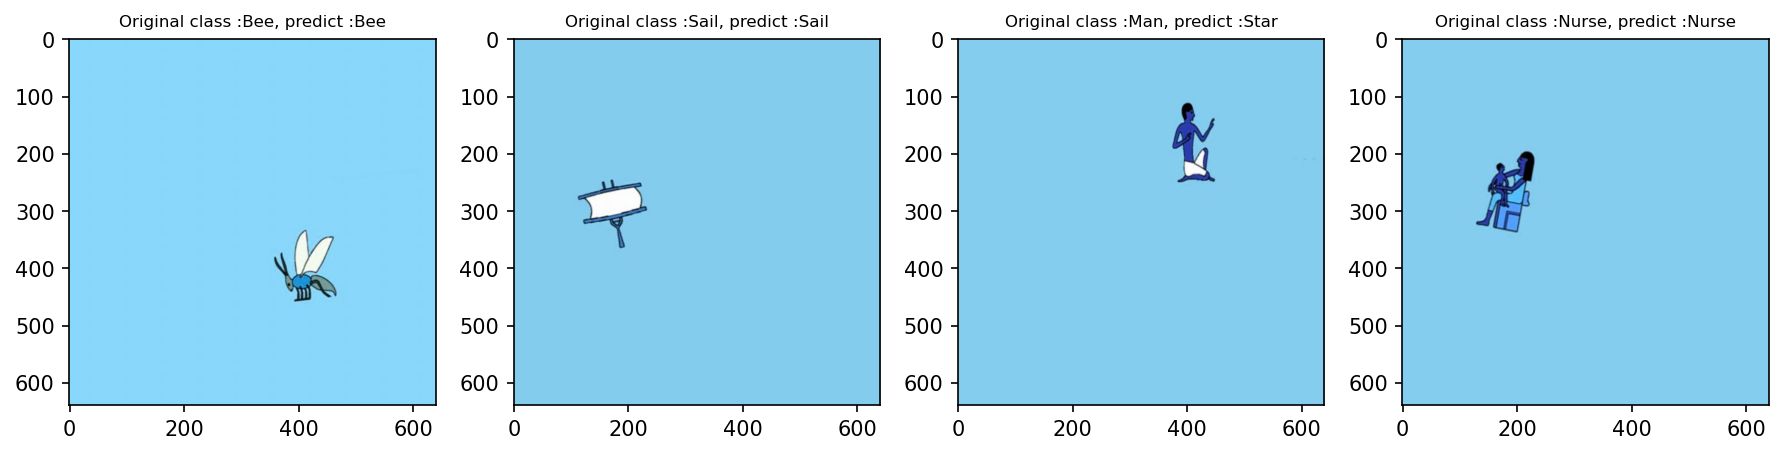

In [15]:
# Original and prediction examples

create_random_samples_and_prediction(test_data, pred_ )